# Project: Build a Traffic Sign Recognition Classifier

## Galen Ballew, January 2017

This notebook contains an upgraded implementation of LeNet architecture to train a convolutional neural net to detect and classify road signs that may be seen from a dash cam in a self driving car. The CNN is implemented using TensorFlow. The images used are from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

---
## Step 0: Load The Data

In [45]:
# Load pickled data
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [46]:
# Number of training examples
n_train = len(X_train) 

# Number of testing examples.
n_test = len(X_test) 

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape 

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train)) #set() returns unordered collection of unique elements

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Visualizations

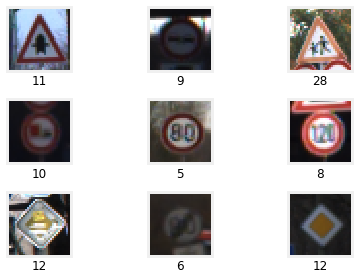

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

#make a grid
fig, ax= plt.subplots(nrows=3, ncols=3)
fig.tight_layout()
flat = [axis for row in ax for axis in row]

#hide the messy ticks 
for axis in flat:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.tick1On = axis.tick2On = False
    axis.label1On = axis.label2On = False

#include the image and the label
for i in range(3):
    for j in range(3):
        index = random.randint(0,len(X_train))
        img = X_train[index]
        class_id = y_train[index]
        ax[i][j].set_xlabel(class_id)
        ax[i][j].imshow(img)
    
plt.show()

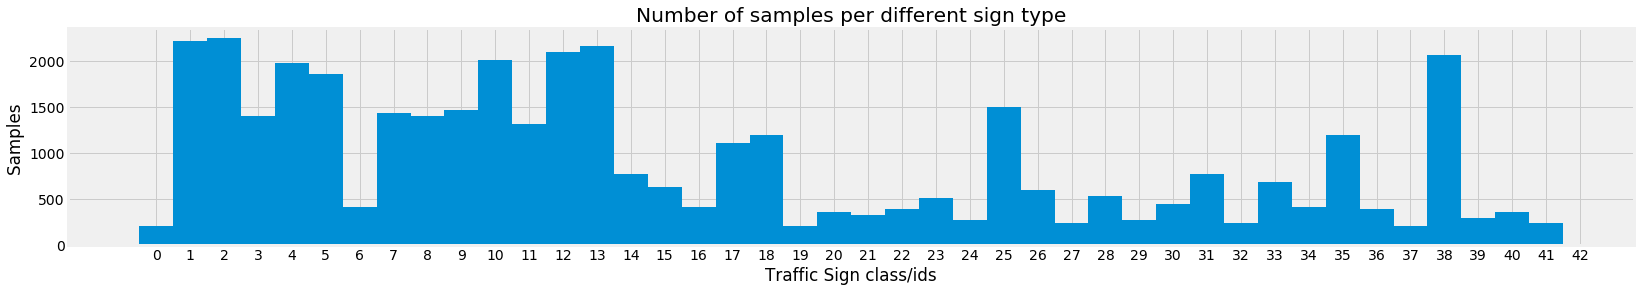

In [48]:
def make_histogram(labels, string):
    samples_per_class = np.bincount(labels)
    x_tix = range(43)
    bins = np.arange(43) - 0.5
    fig = plt.figure(figsize=(25,4))
    plt.style.use('fivethirtyeight')
    ax1 = fig.add_subplot(1,1,1)
    plt.hist(y_train,bins)
    plt.title("Number of samples per different sign type" + string, loc='center')  
    plt.xlabel("Traffic Sign class/ids"); plt.ylabel("Samples ")
    plt.xticks(np.arange(min(x_tix), max(x_tix)+1, 1.0))
    plt.show();
    
make_histogram(y_train, "");

There is a csv file included in the directory which acts as a dictionary for sign id number and type of sign 

In [49]:
import pandas as pd

names_ids = pd.read_csv('signnames.csv')
names_ids.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


----

## Step 2: Design and Test a Model Architecture

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake (or additional) data

You can read more about LeNet architecture and convolutional neural networks [here](http://cs231n.github.io/convolutional-networks/#case). 

In [40]:
import cv2

#TODO: fix this
#http://stackoverflow.com/questions/15007304/histogram-equalization-not-working-on-color-image-opencv
# def histogram_equalization(img_array):
#     for i in range(len(img_array)):
#         img_yuv = cv2.cvtColor(img_array[i], cv2.COLOR_BGR2YUV)
#         img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
#         img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
#     return img_output

#normalizing pixel values [0,1]. 
#TODO:Could aslo normalize from [-1,1] 
#see how this effects TRAINING score (not test score!! no cheating!)
def normalize(img):
    img_array = np.asarray(img)
    normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())
    return normalized

# X_train = histogram_equalization(X_train)
# X_test = histogram_equalization(X_test)

X_train = normalize(X_train)
X_test = normalize(X_test)


I was not able to process the histogram equalization for the RGB images successfully. I was interested in attempting this in order to achieve the best of both worlds - the H.E. would mean more contrast in the image and the CNN would have an easier time making distinctions, meanwhile staying in RGB and avoiding grayscale means that images with shadows, taken at night, or with motion blur, do not suffer as extreme a penalty. 

### Normalization
Normalization is an important part of pre-processing data so that everything is on a relative scale. For RGB images, pixel values range from 0 to 255 and are thus already normalized. However, we can apply further normalization to scale the values from 0 to 1 or -1 to 1. When possible, it's best to avoid large numbers because smaller numbers are both faster and more computationally stable. 

In [41]:
from sklearn.model_selection import train_test_split

#stratify param ensures same distribution of labels. important since there is a high variance in number of samples per label
#histograms of the new split sets will be the very, very similiar to the original set
X_train_split, X_validate_split, y_train_split, y_validate_split = train_test_split(X_train, y_train, 
                                                    test_size=0.2, 
                                                    random_state=666, 
                                                    stratify=y_train)

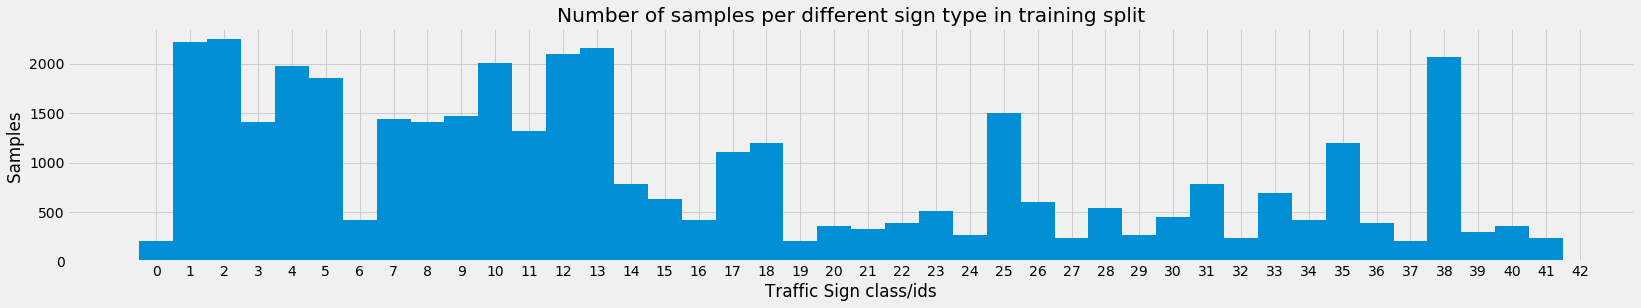

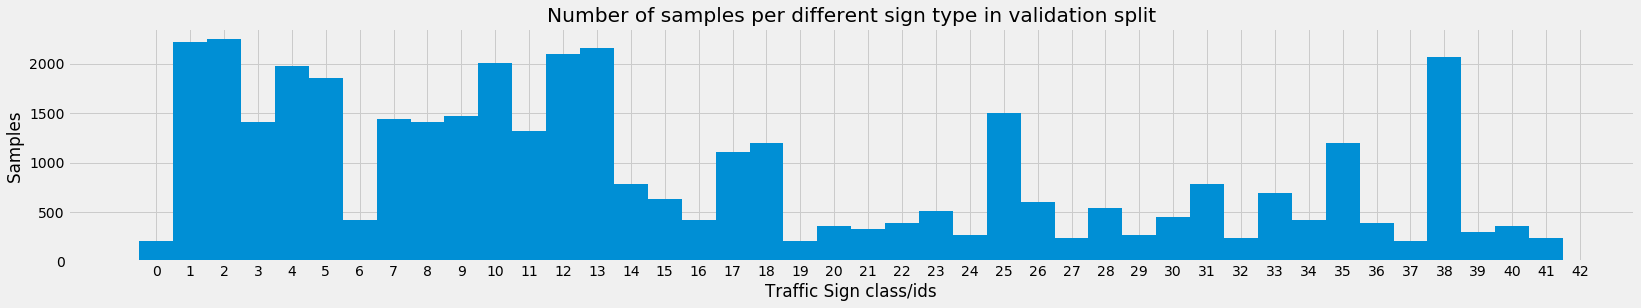

In [42]:
#training split
make_histogram(y_train_split, " in training split")

#validation split
make_histogram(y_validate_split, " in validation split")




### Training, Validation, & Testing

The original training and testing sets are in a ratio of roughly 70/30. This is a relatively large test set. Therefore, I decided to make the training | validation split 80/20. This could be a more aggressive 90/10, but the CNN will still be receiving a very large number of samples for training and the validation will help to deter overfitting. 

In [43]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

X_train_split, y_train_split = shuffle(X_train_split, y_train_split)
X_validate_split, y_validate_split = shuffle(X_validate_split, y_validate_split)

EPOCHS = 150
BATCH_SIZE = 128
LEARNING_RATE = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

#added after initial training in order to retrieve collection for testing new data in part 7
tf.add_to_collection('x', x)
tf.add_to_collection('y', y)
tf.add_to_collection('keep_prob', keep_prob)

In [44]:
#workaround for runing TF on my GPU. something with one_hot encoding overwhelms the CPU. 
#https://github.com/tensorflow/tensorflow/issues/6509
num_labels = 43
sparse_labels = tf.reshape(y, [-1, 1])
derived_size = tf.shape(sparse_labels)[0]
indices = tf.reshape(tf.range(0, derived_size, 1), [-1, 1])
concated = tf.concat(1, [indices, sparse_labels])
outshape = tf.concat(0, [tf.reshape(derived_size, [1]), tf.reshape(num_labels, [1])])
one_hot_y = tf.sparse_to_dense(concated, outshape, 1.0, 0.0)

In [11]:
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    #Conv / ReLU / Max Pool
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Conv / ReLU / Max Pool
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    fc0 =  flatten(conv2)
       
    # Fully Connected / ReLu / Dropout
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 1024), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    fc1_drop = tf.nn.dropout(fc1, keep_prob)

    # Fully Connected / ReLu / Dropout
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024,512), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(512))
    fc2 = tf.matmul(fc1_drop, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2_drop = tf.nn.dropout(fc2, keep_prob)

    # Fully Connected 
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(512, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    weights = [conv1_W,conv2_W,fc1_W,fc2_W,fc3_W]
    
    #added after initial training in order to retrieve collection for testing new data in part 7
    tf.add_to_collection('logits', logits)
    
    return logits,weights

In [12]:
logits,weights = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)

# L2 Regularization 
regularizers = 0.0
for w in weights:
    regularizers += tf.nn.l2_loss(w)

In [13]:
# See notes below on l2 params
#http://docs.aws.amazon.com/machine-learning/latest/dg/training-parameters.html
L2_strength = 1e-6
loss_operation = tf.reduce_mean(cross_entropy) + L2_strength * regularizers
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#added after initial training in order to retrieve collection for testing new data in part 7
tf.add_to_collection('accuracy_operation', accuracy_operation)


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_accuracy / num_examples,total_loss / num_examples

In [15]:
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.per_process_gpu_memory_fraction=0.3

In [16]:
import os

save_dir = './'

In [17]:
with tf.device('/gpu:0'):
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train_split)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train_split, y_train_split = shuffle(X_train_split, y_train_split)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train_split[offset:end], y_train_split[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            training_accuracy,training_loss = evaluate(X_train_split, y_train_split)
            validation_accuracy,validation_loss = evaluate(X_validate_split, y_validate_split)

            if i%10 == 0:
                print("EPOCH {} ...".format(i))
                print("Training Accuracy = {:.4f} Validation Accuracy = {:.4f}".format(training_accuracy,validation_accuracy))
                print("Training Loss = {:.4f} Validation Loss = {:.4f}".format(training_loss,validation_loss))
                print()

        saver = tf.train.Saver()
        path = os.path.join(save_dir, 'lenet_traffic_classifier')
        saver.save(sess, path)
        print("Model saved")

Training...

EPOCH 0 ...
Training Accuracy = 0.9225 Validation Accuracy = 0.9180
Training Loss = 0.3148 Validation Loss = 0.3322

EPOCH 10 ...
Training Accuracy = 0.9994 Validation Accuracy = 0.9941
Training Loss = 0.0137 Validation Loss = 0.0363

EPOCH 20 ...
Training Accuracy = 0.9995 Validation Accuracy = 0.9925
Training Loss = 0.0130 Validation Loss = 0.0419

EPOCH 30 ...
Training Accuracy = 0.9981 Validation Accuracy = 0.9903
Training Loss = 0.0178 Validation Loss = 0.0632

EPOCH 40 ...
Training Accuracy = 0.9993 Validation Accuracy = 0.9938
Training Loss = 0.0154 Validation Loss = 0.0538

EPOCH 50 ...
Training Accuracy = 0.9997 Validation Accuracy = 0.9944
Training Loss = 0.0140 Validation Loss = 0.0544

EPOCH 60 ...
Training Accuracy = 1.0000 Validation Accuracy = 0.9963
Training Loss = 0.0134 Validation Loss = 0.0463

EPOCH 70 ...
Training Accuracy = 0.9997 Validation Accuracy = 0.9946
Training Loss = 0.0151 Validation Loss = 0.0688

EPOCH 80 ...
Training Accuracy = 0.9976 Vali

### Model Evaluation

In [18]:
#run model on testing sample
#tf.saver will not run on the GPU so have to soft_place the cpu device
with tf.device('/cpu:0'):
    with tf.Session(config=config) as sess:
        loader = tf.train.import_meta_graph('lenet_traffic_classifier.meta')
        loader.restore(sess, tf.train.latest_checkpoint(save_dir))

        X_test = normalize(X_test)

        test_accuracy,test_loss = evaluate(X_test, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.965




### Convolutional Neural Network Architecture

The architecture used in this CNN is extremely similiar to the LeNet architecture that was implemented in the Udacity LeNet lab. A difference between the original LeNet architecture from 1989 and the one provided, is that a max pooling function has been applied rather than Yann LeCun's original subsampling function.  

In addition, I added two additional processes to the function to help combat overfitting. The first is applying dropout. Dropout applies a Bernoulli distribution to activations (i.e. the values being passed) during the feed-forward phase - essentially zeroing values randomly by $p$, where $p$ is the probabilty the activation will be passed forward successfully. By applying dropout, the network is forced to confirm the values it produces again and again, so that anything that persists is a very generalized signal and not "training-sample-specific" noise.  
During training, I set $p = 0.5$, which I believe is rather high/aggressive, but I felt that there was ample amount of training data and I also used 150 epochs to ensure enough feed-forward phases that the high dropout would not dramatically alter my logits. During evaluation of the test samples, the dropout keep rate

Lastly, I applied L2 regularization to my Cross Entropy error when updating my weights. L2 regularization is used to penalize large errors. By doing this, we prevent our weights from changing too much, too quickly and overfitting our training sample. I used a L2 "strength" of $1E-6$ and found that value in the [Amazon Web Services](http://docs.aws.amazon.com/machine-learning/latest/dg/training-parameters.html).  

### Model Parameters

**Epochs:** 150  
**Batch size:** 128  
**Learning rate:** 0.001  
**Truncated normal mean:** 0.0  
**Truncated normal standard deviation:** 0.1  
**Dropout keep rate:** 0.5  
**L2 regularization strength:** 1E-6  
**Loss optimization algorithm:** *Adam*  

All of these values were chosen as "standard operating procedure" based off the recommendations given in the coursework. The exception to that is the *Adam* algorithm. I decided to use *Adam* instead of stochastic gradient descent. By maintaining a moving average of the gradients, *Adam* is essentially using the idea of momentum to help the gradient descent avoid local minima. What is results in is a larger step size at the cost of taking up much more memory (there are significantly more parameters to store). The advantages of momentum are discussed in this [paper](https://arxiv.org/pdf/1206.5533.pdf) in section 3.1. The paper explicitly states the liklihood that taking momentum into account (i.e. using *Adam*) may not produce better results for extremely large training samples. Given the size of the sample in this project, I thought it was appropriate to implement.  

### How I approached the problem

I studied mathematics in university and am relatively new to programming. As such, I made sure to use code I had already written or had been provided during the coursework. By watching the course videos, reading on Slack, Confluence, and StackOverflow, and a healthy amount of Googling, I was able to successfully debug all of my code. Also, I ended up reading parts of several academic papers in order to understand what the code was actually doing. I found my education in mathematics particularly helpful in understanding the academic language.  

Something that I was interested in both learning more about and actually implementing in my project was the inception module. It was briefly mentioned as a topic in the coursework, but there was no information about to put the idea into action. Through my research, I found that there are entire architectures built around the inception module using the TensorFlow framework. Most notably [GoogLeNet](https://research.google.com/pubs/pub43022.html) and the [Inception-v3](https://arxiv.org/abs/1512.00567). TensorFlow also has [Inception-V4](https://arxiv.org/abs/1602.07261) available on GitHub, but I was extremely intimidated by having to use the Slim library in addition to TensorFlow and then further modifying the entire architecture to suit my needs. Ultimately, I used the resources that were readily available to me and added the processes that were mentioned during the coursework, but also included information about exactly how to implement them. 

---

## Step 3: Test a Model on New Images

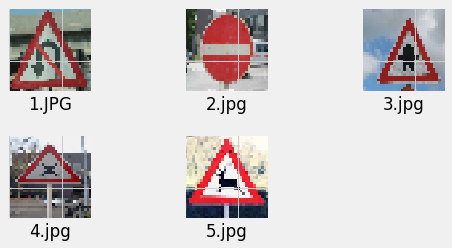

In [19]:
import os
from skimage.transform import resize
import matplotlib.image as mpimg

filenames = os.listdir("test_photos/")

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5)

for index,filename in enumerate(filenames):
    image = mpimg.imread('test_photos/'+filename)
    ax = fig.add_subplot(4,3,index+1)
    ax.set_xlabel(filename)
    image_resize = resize(image, (32, 32))
    plt.imshow(image_resize)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
        tic.label1On = tic.label2On = False
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
        tic.label1On = tic.label2On = False

### Possible problems with the new test images

1) I do not believe this sign is even in the training sample!  
2) This sign is in the training sample, the photo is well lit and not distorted. The model should classify correctly 96% of the time.  
3) I do not know what this sign is or what it means. Let's see if the CNN can tell me.  
4) I do not believe there is a railcrossing sign in the training sample.  
5) The model should predict a wild animal crossing sign 96% of the time.   

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


In [23]:
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
import matplotlib.image as mpimg
import os

config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.per_process_gpu_memory_fraction=0.3

1.JPG
 Class_id: 8  confidence:100%
 Class_id:29  confidence:0%
 Class_id:28  confidence:0%


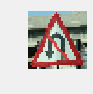

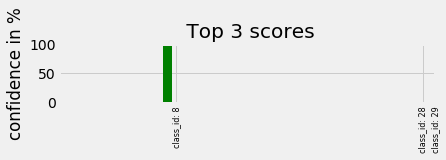

2.jpg
 Class_id:17  confidence:100%
 Class_id: 0  confidence:0%
 Class_id: 1  confidence:0%


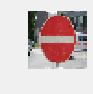

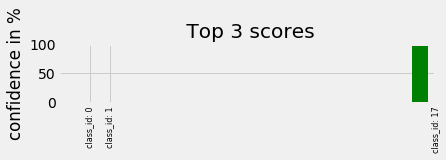

3.jpg
 Class_id:11  confidence:100%
 Class_id: 0  confidence:0%
 Class_id: 1  confidence:0%


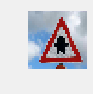

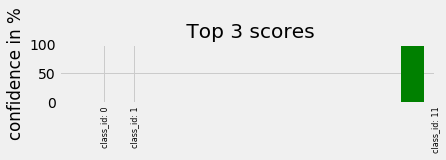

4.jpg
 Class_id:12  confidence:100%
 Class_id:24  confidence:0%
 Class_id: 1  confidence:0%


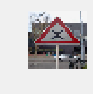

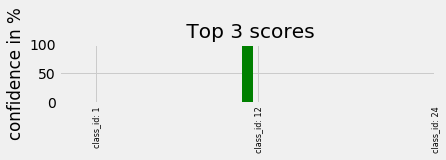

5.jpg
 Class_id:31  confidence:100%
 Class_id: 0  confidence:0%
 Class_id: 1  confidence:0%


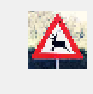

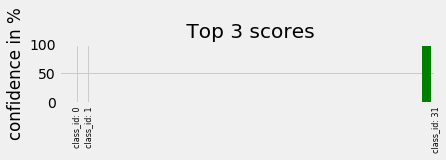

6.jpg
 Class_id: 1  confidence:100%
 Class_id:13  confidence:0%
 Class_id: 2  confidence:0%


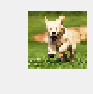

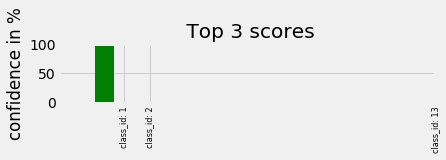

In [51]:
filenames = os.listdir("test_photos/")

with tf.device('/cpu:0'):
    with tf.Session(config=config) as sess:
        loader = tf.train.import_meta_graph('lenet_traffic_classifier.meta')
        loader.restore(sess, tf.train.latest_checkpoint('./'))
    
        accuracy_operation=tf.get_collection('accuracy_operation')[0] #returns list
        x=tf.get_collection('x')[0]
        y=tf.get_collection('y')[0]
        keep_prob=tf.get_collection('keep_prob')[0]
        logits=tf.get_collection('logits')[0]

        predictions =[]
  
        for index,filename in enumerate(filenames):
            image = mpimg.imread('test_photos/'+filename)
            test_image = resize(image, (32, 32))
            #pre-processing
            test_image = normalize(test_image)

            test_prediction = tf.nn.softmax(logits)
            classification = sess.run(test_prediction,feed_dict = {x: [test_image],keep_prob:1.0})
            test_class = sess.run(tf.argmax(classification,1))
            value,indices = sess.run(tf.nn.top_k(tf.constant(classification), k=3))

            predict_confidence=value.squeeze()
            indices = indices.squeeze()
            print(filename)
            fig = plt.figure(figsize=(1,1))
            plt.imshow(test_image)
            plt.axis('off')
            for j in range(0,3):
                print ( ' Class_id:{0:2d}  confidence:{1:.0%}'.format((indices[j]),(predict_confidence[j])))

            classes = indices.squeeze() 
            width = 0.75      
            fig = plt.figure(figsize=(6,1))
            ax = fig.add_subplot(1, 1, 1)

            rect = ax.bar(classes, predict_confidence*100, width,
                    color='green')

            # axes and labels
            ax.set_xlim(-width,len(classes)+width)
            ax.set_ylim(0,100)
            ax.set_ylabel('confidence in %')
            ax.set_title(' Top 3 scores')
            xTickMarks = ['class_id: '+str(classes[k]) for k in range(0,len(classes))]
            ax.set_xticks(classes+width)
            xtickNames = ax.set_xticklabels(xTickMarks)
            plt.setp(xtickNames, rotation=90, fontsize=8)
            plt.show()
            plt.close

### Confidence and conclusion

#### Image 1
This image was classifed incorrectly with 100% confidence.   
#### Image 2
**Correct** with 100% confidence.  
#### Image 3
This image was classifed incorrectly with 100% confidence.   
#### Image 4
This image was classifed incorrectly with 100% confidence.   
#### Image 5
**Correct** with 100% confidence.  
#### Image 6
This image was classifed incorrectly with 100% confidence.  

At this point in the project, I have trained my model many, many times and spent hours working on this. I felt very good looking at my training, validation, and test error rates! But now my world is shattered.... I do not know what this means. Yes, I did supply the model with 4 new signs that were not in the training set. Yes, it classified the 2 signs it had learned from correctly. But ** *WHY* ** did it get the new images wrong with ***100% confidence?!*** This I do not know. I was underthe impressed that softmax would convert numerous logits into probabilities and they would be compared against my one hot encoded labels. Instead, I seem to have one and only one probability regardless of input.  

Basically, I have absolutely no idea whether or not my neural network works! This would be a danger to humanity if it were put out on to the road. In the end, I do not know what I do not know.  

This was a fun project. I'm proud of the work I've done. I'm glad it's over.